In [3]:
import pandas as pd
import numpy as np
import spacy
import gensim
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk import SnowballStemmer
from collections import Counter
from collections import defaultdict
# import numba
# from numba.experimental import jitclass
# from numba import jit,njit,cuda
import re
import os
import matplotlib.pyplot as plt
plt.style.use("ggplot")

nltk.download("stopwords")

nlp = spacy.load("en_core_web_sm")
stopwords = list(stopwords.words("english"))
punt = [ele for ele in punctuation]
no_word = stopwords+ punt
stemmer = SnowballStemmer("english")



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laudi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
PATH_FIND = re.compile(r".*repository.")
rep_path = re.search(PATH_FIND,os.getcwd()).group()

In [3]:
# rep_path

In [4]:
# spacy.require_gpu()

In [5]:

nlp = spacy.load("en_core_web_sm")

In [6]:
%load_ext cython

In [7]:
# %%cython
# import pandas as pd
# df = pd.read_csv("C:\\Users\\laudi\\OneDrive\\Desktop\\Tesi_workspace\\repository\\1 csv\\patent_data_RAW.csv",sep=",", nrows=100000)
    

In [11]:
def read_dataset (path):
    df = pd.read_csv(os.path.join(path,"1 csv","patent_data_RAW.csv"),sep=",")
    return df

In [9]:
%time df = read_dataset(rep_path)

CPU times: total: 39.4 s
Wall time: 1min 3s


In [10]:
df["issue_date_year"] = df.issue_date.apply(lambda x : str(x)[-4:])

In [11]:
# fraction = len(df)//4
# df_1 = df.iloc[:100,:]
# df_2 = df.iloc[fraction:fraction*2,:]
# df_3 = df.iloc[fraction*2:fraction*3,:]
# df_4 = df.iloc[fraction*3:,:]

In [12]:
#@numba.jit
# %%cython

# df = pd.read_csv(os.path.join(rep_path,"1 csv","patent_data_RAW.csv"),sep=",", nrows=100000)
    
# r"C:/Users/alessandro.laudisa/OneDrive - Accenture/Desktop/Tesi_workspace/repository/1 csv/patent_data_RAW.csv", sep=",", nrows=10000)

In [13]:
df.columns

Index(['Unnamed: 0', 'id', 'type', 'number', 'country', 'date', 'abstract',
       'title', 'kind', 'num_claims', 'filename', 'withdrawn', 'uuid',
       'patent_id', 'section_id', 'subsection_id', 'group_id', 'subgroup_id',
       'category', 'patent_num', 'xi_real', 'xi_nominal', 'cites', 'permno',
       'issue_date', 'filing_date', 'issue_date_year'],
      dtype='object')

In [14]:
# abstract_1 = df_1.abstract
# abstract_2 = df_2.abstract
# abstract_3 = df_3.abstract
# abstract_4 = df_4.abstract

In [27]:
sample = df.sample(50000,random_state=1998)

# AbstactAnalysis

In [94]:


# spec = [
#     ('abstract', "reflected list(unicode_type)"),               # a simple scalar field
#     ('tokens', "unicode_type"),          # an array field
#     ('lemmas', "unicode_type"), 
#     ('names', "unicode_type"), 
#     ('count', "unicode_type"),
#     ('filt_content', "unicode_type"), 
# ]


# @jitclass(spec)
class AbstractAnalysis(object):
    
    def __init__(self, df, name_col_abs):
        self.df = df
        self.abstract = self.df[name_col_abs]
        
        #self.tokens = None
        #self.lemmas = None
        #self.stems = None
        #self.entities = None
        self.names = None
        self.count = None
        self.filt_content = None
    
    
    #@jit(forceobj=True)
    def nlp_apply(self, x, type_ = "tokens", set_ = {'NOUN','VERB','PROPN','ADJ','ADV'} ):
        list_ = []
        
        if type_ == "tokens":
            for token in nlp(x):
                if token.text not in no_word:
                    list_.append(token.text)
            return list_ 
        
        elif type_ == "lemmas":
            for token in nlp(x, disable=['parser', 'ner']):
                if token.text not in no_word:
                    list_.append(token.lemma_)
            return list_ 
        
        elif type_ == "stems":
            for token in x.split():
                if token.lower() not in no_word:
                    list_.append(stemmer.stem(token))
            return list_ 
        
#         elif type_ == "pos":
       
#             for token in nlp(x):
#                 # if token.pos_ in set_:
                
#                 list_.append(token.pos_)
        
    def decomposition(self, type_ = "tokens", set_ ={'NOUN','VERB','PROPN','ADJ','ADV'}):
        new_var = self.abstract.apply(lambda x: self.nlp_apply(x, type_= type_, set_=set_))
        if type_ == "tokens":
            self.df["tokens"] = new_var
            return new_var
        elif type_ == "lemmas":
            self.df["lemmas"] = new_var
            return new_var
        elif type_ == "stems":
            self.df["stems"] = new_var
            return new_var
#         elif type_ == "pos":
#             self.df["pos"] = new_var
#             return new_var
    
    # def decomposition(self):
    #     #nlp = spacy.load("en_core_web_sm")
    #     self.tokens  = [token.text.lower()  for sentence in self.abstract for token in nlp(sentence,disable=[ "parser", "ner"]) if token.text not in no_word]
    #     #self.lemmas  = [token.lemma_.lower()  for sentence in self.abstract for token in nlp(sentence,disable=["tagger", "parser", "ner"]) if token.text not in no_word]
    #     #self.stems   = [stemmer.stem(token).lower() for sentence in self.abstract for token in sentence.split() if token not in no_word]
    #     #self.entities = [entity.text for sentence in self.abstract for entity in nlp(sentence).ents if entity.label_ == "PERSON"]
        
        
    #possible the choice of Noun and Propn
    # def pos_a (self, set_ = {'NOUN','VERB','PROPN','ADJ','ADV'}):
    #     filtered_pos = [token.text for sentence in self.abstract for token in nlp(sentence) if token.pos_ in set_] #get all the words
    #     self.df["fil_pos"] = filtered_pos
        
        
    def find_name(self, set_ = {'NOUN'}):
        name = []
        counter_ = 0
        for sentence in self.abstract:
            name.append([])
            for token in nlp(sentence):
                if token.pos_  in set_:
                    name[counter_].append(token.text)
            counter_ += 1
        self.df["noun"] = name
        
    def transform_onelist(self, serie):
        list_ = []
        for single_list in serie: 
            for ele in single_list:
                list_.append(ele)
        return list_
        
        
    def counter(self, cat = "lemmas", n=10): 
        count = Counter()
        if   cat == "lemmas":
            count.update(self.transform_onelist(self.df.lemmas))
        elif cat == "tokens":
            count.update(self.transform_onelist(self.df.tokens))
        elif cat == "stems":
            count.update(self.transform_onelist(self.df.tokens))
        elif cat == "noun":
            count.update(self.transform_onelist(self.df.noun))
        self.count = count
        return count.most_common(n)
        
    def save_df(self):
        self.df.to_csv("raw_all_component.csv")
        
        

In [95]:
AA_1 = AbstractAnalysis(sample, "abstract")

In [30]:
%time AA_1.decomposition("tokens")

CPU times: total: 8min 11s
Wall time: 12min 46s


1220007    [A, method, apparatus, adding, fill, clock, pu...
344899     [ , A, rotary, cutting, blade, assembly, remov...
1116045    [A, field, sequential, liquid, crystal, displa...
184501     [Disclosed, system, method, collecting, trace,...
478813     [ , A, fire, truck, characterized, reduced, op...
                                 ...                        
1969407    [A, touch, sensor, panel, including, plurality...
1355275    [An, open, cable, set, top, box, diagnosing, s...
1419861    [A, tunable, filter, circuit, inputs, IN1, IN2...
1912399    [A, method, disclosed, forming, semiconductor,...
21002      [A, lighting, device, vehicle, may, include, l...
Name: abstract, Length: 50000, dtype: object

In [96]:
AA_1.decomposition("lemmas")

1220007    [a, method, apparatus, add, fill, clock, pulse...
344899     [ , a, rotary, cutting, blade, assembly, remov...
1116045    [a, field, sequential, liquid, crystal, displa...
184501     [disclose, system, method, collect, trace, dat...
478813     [ , a, fire, truck, characterize, reduce, oper...
                                 ...                        
1969407    [a, touch, sensor, panel, include, plurality, ...
1355275    [an, open, cable, set, top, box, diagnose, sys...
1419861    [a, tunable, filter, circuit, input, IN1, IN2,...
1912399    [a, method, disclose, form, semiconductor, dev...
21002      [a, lighting, device, vehicle, may, include, l...
Name: abstract, Length: 50000, dtype: object

In [32]:
AA_1.decomposition("stems")

1220007    [method, apparatus, ad, fill-in, clock, puls, ...
344899     [rotari, cut, blade, assembl, remov, rubber, t...
1116045    [field, sequenti, liquid, crystal, display, ap...
184501     [disclos, system, method, collect, trace, data...
478813     [fire, truck, character, reduc, oper, nois, le...
                                 ...                        
1969407    [touch, sensor, panel, includ, plural, drive, ...
1355275    [open, cabl, set-top, box, diagnos, system, po...
1419861    [tunabl, filter, circuit, input, in1-in2, outp...
1912399    [method, disclos, form, semiconductor, device....
21002      [light, devic, vehicl, may, includ, light, sou...
Name: abstract, Length: 50000, dtype: object

In [33]:
# AA_1.decomposition("pos")

In [98]:
rep_path

'C:\\Users\\laudi\\OneDrive\\Desktop\\Tesi_workspace\\repository\\'

In [99]:
new = pd.read_csv(rep_path+ "99 generated csv\\ch 2\\raw_all_component.csv")

In [100]:
new.lemmas = AA_1.df.lemmas

In [102]:
new.to_csv(rep_path+ "99 generated csv\\ch 2\\raw_all_component2.csv")

In [97]:
AA_1.df.lemmas

1220007    [a, method, apparatus, add, fill, clock, pulse...
344899     [ , a, rotary, cutting, blade, assembly, remov...
1116045    [a, field, sequential, liquid, crystal, displa...
184501     [disclose, system, method, collect, trace, dat...
478813     [ , a, fire, truck, characterize, reduce, oper...
                                 ...                        
1969407    [a, touch, sensor, panel, include, plurality, ...
1355275    [an, open, cable, set, top, box, diagnose, sys...
1419861    [a, tunable, filter, circuit, input, IN1, IN2,...
1912399    [a, method, disclose, form, semiconductor, dev...
21002      [a, lighting, device, vehicle, may, include, l...
Name: lemmas, Length: 50000, dtype: object

In [38]:
%time AA_1.find_name()

CPU times: total: 13min 56s
Wall time: 28min 59s


In [41]:
AA_1.save_df()

In [36]:
a = 1

In [103]:
AA_1.counter("lemmas",n=50)

[('the', 69757),
 ('a', 41946),
 ('first', 41700),
 ('include', 40108),
 ('second', 32408),
 ('one', 30787),
 ('device', 30287),
 ('system', 26323),
 ('method', 25829),
 ('provide', 25739),
 ('signal', 23317),
 ('use', 20422),
 ('datum', 19688),
 ('layer', 19331),
 ('may', 19184),
 ('form', 18646),
 ('least', 17495),
 ('control', 16879),
 ('base', 15627),
 ('portion', 15533),
 (' ', 14889),
 ('plurality', 14245),
 ('surface', 13942),
 ('comprise', 13678),
 ('receive', 13616),
 ('image', 13450),
 ('circuit', 12954),
 ('information', 12447),
 ('in', 11408),
 ('unit', 11292),
 ('user', 10923),
 ('apparatus', 10731),
 ('position', 10585),
 ('invention', 10054),
 ('member', 9933),
 ('an', 9740),
 ('material', 9519),
 ('output', 9379),
 ('network', 9375),
 ('determine', 9325),
 ('substrate', 9324),
 ('element', 9246),
 ('process', 9058),
 ('power', 8855),
 ('end', 8669),
 ('also', 8600),
 ('generate', 8565),
 ('communication', 8388),
 ('memory', 8366),
 ('time', 8365)]

In [85]:
AA_1.counter("tokens",n=50)

[('The', 69747),
 ('A', 42552),
 ('first', 41462),
 ('second', 32288),
 ('one', 29189),
 ('data', 27005),
 ('device', 25578),
 ('includes', 25235),
 ('system', 22714),
 ('method', 19732),
 ('may', 19183),
 ('signal', 17812),
 ('least', 17495),
 ('layer', 17019),
 (' ', 14889),
 ('plurality', 14206),
 ('portion', 12790),
 ('provided', 12514),
 ('information', 12309),
 ('surface', 12265),
 ('control', 12079),
 ('circuit', 11573),
 ('image', 11429),
 ('In', 11403),
 ('based', 10720),
 ('apparatus', 10337),
 ('invention', 10044),
 ('user', 9891),
 ('unit', 9754),
 ('An', 9741),
 ('network', 8808),
 ('substrate', 8722),
 ('power', 8494),
 ('material', 8412),
 ('formed', 8215),
 ('memory', 8184),
 ('member', 8099),
 ('output', 8073),
 ('including', 7823),
 ('configured', 7802),
 ('also', 7714),
 ('input', 7617),
 ('using', 7572),
 ('time', 7540),
 ('within', 7471),
 ('end', 7417),
 ('light', 7370),
 ('position', 7204),
 ('wherein', 6839),
 ('used', 6830)]

In [86]:
AA_1.counter("stems",n=50)

[('The', 69747),
 ('A', 42552),
 ('first', 41462),
 ('second', 32288),
 ('one', 29189),
 ('data', 27005),
 ('device', 25578),
 ('includes', 25235),
 ('system', 22714),
 ('method', 19732),
 ('may', 19183),
 ('signal', 17812),
 ('least', 17495),
 ('layer', 17019),
 (' ', 14889),
 ('plurality', 14206),
 ('portion', 12790),
 ('provided', 12514),
 ('information', 12309),
 ('surface', 12265),
 ('control', 12079),
 ('circuit', 11573),
 ('image', 11429),
 ('In', 11403),
 ('based', 10720),
 ('apparatus', 10337),
 ('invention', 10044),
 ('user', 9891),
 ('unit', 9754),
 ('An', 9741),
 ('network', 8808),
 ('substrate', 8722),
 ('power', 8494),
 ('material', 8412),
 ('formed', 8215),
 ('memory', 8184),
 ('member', 8099),
 ('output', 8073),
 ('including', 7823),
 ('configured', 7802),
 ('also', 7714),
 ('input', 7617),
 ('using', 7572),
 ('time', 7540),
 ('within', 7471),
 ('end', 7417),
 ('light', 7370),
 ('position', 7204),
 ('wherein', 6839),
 ('used', 6830)]

In [87]:
AA_1.counter("noun",n=50)

[('data', 26851),
 ('device', 25568),
 ('system', 22708),
 ('method', 19659),
 ('signal', 17118),
 ('layer', 16798),
 ('plurality', 14206),
 ('portion', 12787),
 ('information', 12306),
 ('surface', 12179),
 ('circuit', 11536),
 ('image', 11384),
 ('control', 10584),
 ('apparatus', 10313),
 ('invention', 10044),
 ('user', 9842),
 ('unit', 9749),
 ('network', 8799),
 ('power', 8453),
 ('material', 8384),
 ('memory', 8183),
 ('member', 8095),
 ('substrate', 7796),
 ('output', 7746),
 ('time', 7533),
 ('input', 7405),
 ('end', 7218),
 ('position', 7071),
 ('communication', 6726),
 ('voltage', 6469),
 ('structure', 6177),
 ('region', 6167),
 ('source', 5917),
 ('side', 5847),
 ('process', 5765),
 ('element', 5689),
 ('assembly', 5600),
 ('processing', 5558),
 ('semiconductor', 5532),
 ('value', 5472),
 ('storage', 5433),
 ('display', 5354),
 ('body', 5107),
 ('methods', 4913),
 ('signals', 4865),
 ('operation', 4769),
 ('line', 4697),
 ('component', 4669),
 ('vehicle', 4662),
 ('computer',

with jit: 
* CPU times: total: 17.9 s
* Wall time: 34.6 s

without jit: 
* CPU times: total: 22.4 s
* Wall time: 27.4 s 

10000 osservazioni tempo di processazione

CPU times: total: 28.5 s
Wall time: 41.8 s

# TFIDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt

In [57]:
abstract = sample.abstract

In [12]:
# read in the data and transform it

class TFIDF(object):
    def __init__(self,abstract):
        self.abstract = abstract
        #self.corpus = [[token.text for token in nlp(new_sentence)] for new_sentence in self.abstract]
        self.names = None
        self.idf = None
        self.tfidf = None 
        self.counvec = None
        self.df_tfidf = None 
        
    def settingmodeltfidf(self, ngram_range_ = (1,1), analyzer_ ="word", min_df_=0.001, max_df_=0.7):
        
        tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range_, 
                                   stop_words='english', 
                                   analyzer=analyzer_, 
                                   min_df=min_df_, 
                                   max_df=max_df_, 
                                   sublinear_tf=True, 
                                   use_idf=True)
        
        tfidf = tfidf_vectorizer.fit_transform(self.abstract)
        
        self.tfidf = tfidf
        
        self.idf = tfidf_vectorizer.idf_ 
        
        return tfidf
        
#df = pd.read_excel('../data/reviews.xlsx', nrows=100000)
#df = df[df.clean_text.isna()==False] # drop all reviews without text
#documents = df.clean_text.apply(str).tolist() # make sure they are strings



    def settingmodelcountVec(self, ngram_range_ = (1,1), analyzer_ ="word", min_df_=0.001, max_df_=0.7):
        


        count_vectorizer = CountVectorizer(ngram_range=ngram_range_, 
                                           stop_words='english', 
                                           analyzer=analyzer_, 
                                           min_df=min_df_, 
                                           max_df=max_df_)

        counvec = count_vectorizer.fit_transform(self.abstract)
        
        self.names = count_vectorizer.get_feature_names_out()
        
        self.counvec = counvec
        
        
    def array(self):

        word_counts = self.counvec.toarray()
        word_tfidf = self.tfidf.toarray()

        df_tfidf = pd.DataFrame(data = {'word': self.names,
                                        'tf': word_counts.sum(axis = 0),
                                        'idf': self.idf,
                                        'tfidf': word_tfidf.sum(axis=0)})

        df_tfidf = df_tfidf.sort_values(['tfidf','tf','idf'])
        
        self.df_tfidf = df_tfidf

        return df_tfidf

#### PLOT
    def plot(self):
        
        fig, ax = plt.subplots(figsize = (16,12))

        self.df_tfidf['tf'] *= 3

        self.df_tfidf.plot.scatter(x = 'tfidf',
                                y = 'idf',
                                s = 'tf',
                                ax = ax,
                                alpha = 1,
                                edgecolor = 'k'
                                #ylim = (1,8),
                                #xlim = (0,4000)
                                  );

    def getsorted(self, n=20):
        
        return self.array().sort_values("tfidf",ascending=False).iloc[:n,:]
# #### plot_word
#         fig, ax = plt.subplots(figsize = (16,12))

#         self.df_tfidf['tf'] /= 10

#         self.df_tfidf.iloc[:1000,:].plot.scatter(x = 'tfidf',
#                                 y = 'idf',
#                                 s = 'tf',
#                                 ax = ax,
#                                 alpha = 1,
#                                 edgecolor = 'k');

#         for label, x, y in zip(self.df_tfidf.iloc[:1000,0], self.df_tfidf.iloc[:1000,3], self.df_tfidf.iloc[:1000,2]):
#                     txt = plt.annotate(label,xy=(x, y))
        plt.show()

In [110]:
"""ngram_range=ngram_range_, 
                                   stop_words='english', 
                                   analyzer=analyzer_, 
                                   min_df=min_df_, 
                                   max_df=max_df_, 
                                   sublinear_tf=True, 
                                   use_idf=True""".split(", ")

['ngram_range=ngram_range_',
 "\n                                   stop_words='english'",
 '\n                                   analyzer=analyzer_',
 '\n                                   min_df=min_df_',
 '\n                                   max_df=max_df_',
 '\n                                   sublinear_tf=True',
 '\n                                   use_idf=True']

In [65]:
tfidf_ = TFIDF(abstract)

In [66]:
tfidf_.settingmodeltfidf()
tfidf_.settingmodelcountVec()

In [67]:
arr = tfidf_.getsorted()

In [104]:
arr.to_csv(rep_path+ "99 generated csv\\ch 2\\ordered_tfidf.csv")

In [73]:
# tfidf_.df_tfidf.to_csv("tfidf.csv")

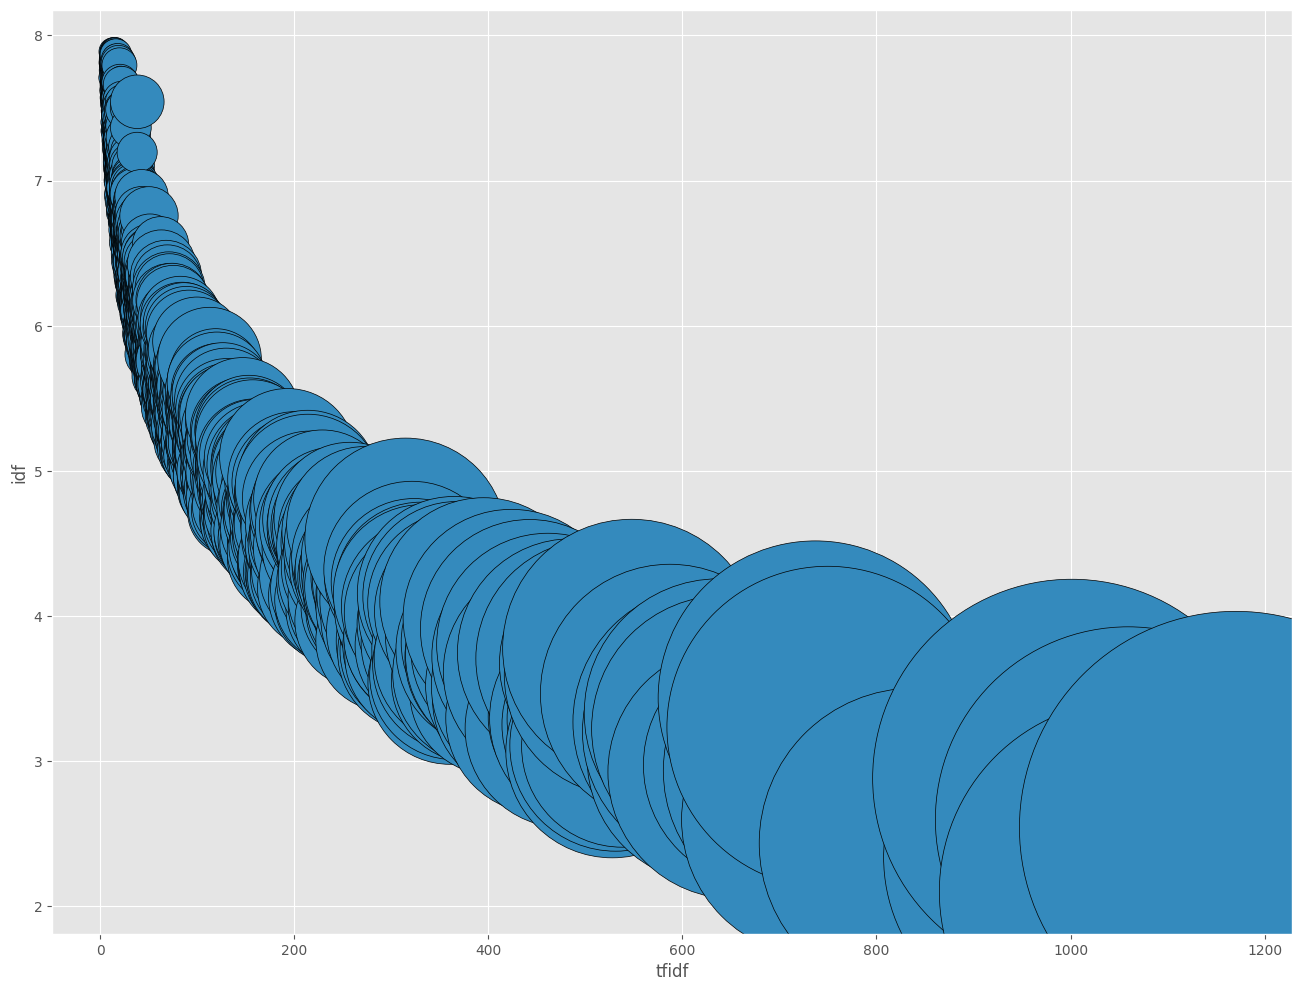

In [69]:
tfidf_.plot()

In [ ]:
# arr.sort_values("tfidf",ascending=False).iloc[:20,:]

#### TEST 2020

In [7]:
test_2020 = pd.read_csv(r"C:\Users\laudi\OneDrive\Desktop\Tesi_workspace\repository\99 generated csv\ch 3\test_2020.csv")

In [10]:
abstract_2020 = test_2020.abstract

In [13]:
tfidf_ = TFIDF(abstract_2020 )

In [18]:
tfidf_.settingmodeltfidf(ngram_range_=(1, 1), analyzer_= "word", min_df_= 0.01, max_df_ = 0.85)
tfidf_.settingmodelcountVec(ngram_range_=(1, 1), analyzer_= "word", min_df_= 0.01, max_df_ = 0.85)

In [19]:
arr = tfidf_.getsorted()

In [20]:
arr

,word,tf,idf,tfidf
482,second,95747,2.212174,4410.690136
148,device,79762,2.260818,3930.837164
268,includes,71312,1.824098,3909.867131
128,data,72176,2.557402,3575.059455
335,method,47397,2.267787,3214.860712
47,based,45461,2.246773,3005.442922
403,plurality,41449,2.715722,2792.761373
105,configured,36659,2.630208,2651.611214
586,user,39764,2.951111,2542.846558
277,information,32458,3.035830,2272.771652


# Latent Dimension

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD # this also works with sparse matrices
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv(rep_path+ "99 generated csv\\ch 2\\raw_all_component2.csv")
abstract = df.abstract

In [24]:
class LatentDimension(object):
    def __init__(self, abstract):
    # set number of latent components
    
        self.abstract = abstract
        
        
        self.term = None
        
        self.svd2 = None
        self.U2 = None 
        self.S2 = None
        self.V2 = None

        self.svd3 = None
        self.U3 = None
        self.S3 = None
        self.V3 = None
        
        self.Uk = None
        self.Sk = None
        self.Vk = None
        
        self.svdk = None
        self.X = None
    
    def set_tfidf(self, ngram_range_ = (1,1), analyzer_ ="word", min_df_=0.001, max_df_=0.7):
        
        tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range_, 
                                   stop_words='english', 
                                   analyzer=analyzer_, 
                                   min_df=min_df_, 
                                   max_df=max_df_, 
                                   sublinear_tf=True, 
                                   use_idf=True)
        
        self.X = tfidf_vectorizer.fit_transform(self.abstract)
        
        
        
        self.term = tfidf_vectorizer.get_feature_names_out()
        
    def specific_dim(self, k):
        svdk = TruncatedSVD(n_components=k)
        self.Uk = svdk.fit_transform(self.X)
        self.Sk = svdk.singular_values_
        self.Vk = svdk.components_
        
    
    # def setmodel_plot(self):
        
    #     svd2 = TruncatedSVD(n_components=2)
    #     self.U2 = svd2.fit_transform(self.X)
    #     self.S2 = svd2.singular_values_
    #     self.V2 = svd2.components_

    #     svd3 = TruncatedSVD(n_components=3)
    #     self.U3 = svd3.fit_transform(self.X)
    #     self.S3 = svd3.singular_values_
    #     self.V3 = svd3.components_
        
    def show_topics(self, A, vocabulary, topn):
        """
        find the top N words for each of the latent dimensions (=rows) in a matrix
        """
        topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                        for t in A])
        return [', '.join(t) for t in topic_words]
    
    def get_topics(self, topn = 5):
        return self.show_topics(self.Vk, self.term, topn)
        
        
        

    

In [14]:
LD = LatentDimension(abstract)

In [15]:
LD.set_tfidf()

In [16]:
LD.specific_dim(3)

In [18]:
# LD.setmodel_plot()

In [19]:
LD.get_topics()

['second, device, data, includes, method',
 'layer, substrate, surface, formed, material',
 'invention, compounds, compositions, formula, present']

## TEST_2020

In [30]:
LD = LatentDimension(abstract_2020)

In [31]:
LD.set_tfidf()

In [32]:
LD.specific_dim(5)

In [33]:
# LD.setmodel_plot()

In [34]:
LD.get_topics()

['second, device, data, includes, method',
 'layer, substrate, surface, semiconductor, second',
 'layer, semiconductor, substrate, user, structure',
 'signal, circuit, voltage, power, wireless',
 'image, unit, display, data, processing']